<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CNN_for_Noise_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo simples de classificação de tipo de ruido em imagens

#### Luis Ricardo Arantes Filho
#### Luan Bingo

Gerador de Ruidos: Rubens Sautter:
An parameter of correction has been used (s):
FFT(f(w)) = gauss(0,std) * (1/w^beta)^(beta*s/2) 
Frequencies are measured in multidimensional space by the frequency euclidian distance.

Parameter for all noise types
size = 128
wn = cNoise(0,(size,size),maxCorrections=100,maxAvgError=0.001, eta=0.05)

#### Coordenador: Dr. Reinaldo R. Rosa
#### National Institute for Space Research

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#ls
%cd drive/MyDrive/INPE/CCN_For_Noise_Classification

/content/drive/MyDrive/INPE/CCN_For_Noise_Classification


In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

#Dataframes devem conter:
    #Imagens Full
    #Class


#caminho de images
path_img_1 = os.getcwd() + '/Noise_images/'

#lista de images
lista_p1 = os.listdir(path_img_1)
lista_p1.sort()

# =============================================================================
# #reading noise images
# =============================================================================
list_img = []
list_class = []

i = 0
for i in range(len(lista_p1)):
    image = cv2.imread(path_img_1+lista_p1[i])
    nome = lista_p1[i].split('.jpg')
    nome = nome[0].split('_')
    classe_noise = nome[3]
#     print(i)
#     print(classe_noise)

    list_img.append(image)
    list_class.append(classe_noise)

df_rect_1 = pd.DataFrame({'image_data':list_img, 'class':list_class})

In [46]:
new_df = df_rect_1.sort_values(by='class',axis=1)

KeyError: ignored

In [44]:
new_df

,image_data,class
0,"[[[154, 154, 154], [148, 148, 148], [138, 138,...",pn
1713,"[[[138, 138, 138], [129, 129, 129], [127, 127,...",pn
852,"[[[154, 154, 154], [131, 131, 131], [108, 108,...",pn
2427,"[[[150, 150, 150], [149, 149, 149], [150, 150,...",pn
1716,"[[[144, 144, 144], [156, 156, 156], [145, 145,...",pn
...,...,...
1484,"[[[216, 216, 216], [198, 198, 198], [162, 162,...",wn
1481,"[[[71, 71, 71], [69, 69, 69], [104, 104, 104],...",wn
1478,"[[[142, 142, 142], [138, 138, 138], [168, 168,...",wn
1508,"[[[169, 169, 169], [160, 160, 160], [169, 169,...",wn


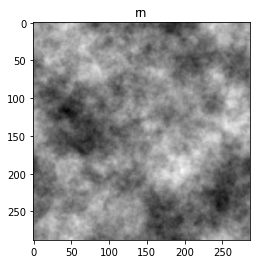

In [48]:
i = 1
plt.imshow(new_df['image_data'][i])
plt.title(new_df['class'][i])
plt.show()

# GENERATE SETS

In [6]:
#Why save this dataframe
path_dataframe = os.getcwd() + '/Dataframes/'
##Salvar esse DF       
def salvaDataFrames_pkl(dataFrame,caminhoSaida,nomeArquivo):
    dataFrame.to_pickle(caminhoSaida+'/'+nomeArquivo, compression='infer')


salvaDataFrames_pkl(df_rect_1,path_dataframe,'Data_Frame_Noise_images.pkl')

In [ ]:
#ADJUST IMG DIM
from PIL import Image
import cv2 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
image_list = []
i = 0
for i in range(len(df_rect_1)):
    print(i)
    #old_im = cv2.imread(df_rect_1.loc[i,'image_data'])    
    res = cv2.resize(df_rect_1.loc[i,'image_data'],(128,128),cv2.INTER_AREA)
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY) #Whay put on gray?
    print(gray.shape)
    image_list.append(gray)
    print(i)

In [8]:
labels = []
i=0
for i in range(len(df_rect_1.index)):
    #(0-white noise, 1-pink noise, 2- red noise)
    if df_rect_1.loc[i,'class'] == 'wn':
        labels.append(0)
    elif df_rect_1.loc[i,'class'] == 'pn':
        labels.append(1)
    elif df_rect_1.loc[i,'class'] == 'rn':
        labels.append(2)

labels = np.array(labels)

In [20]:
labels

array([1, 2, 0, ..., 1, 2, 0])

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

'''
Montar Conjunto de Treinamento - Testes IMAGENS ARTIFICIAIS
'''
#Dividindo Conjunto de treinamento e de Teste
X_train, X_test, y_train, y_test = train_test_split(
    np.asarray(image_list),
    np.asarray(labels),
    test_size=0.20, 
    shuffle=True,
    random_state=42,
)

# Scale images to the [0, 1] range
X_train = X_train.reshape(len(X_train),128,128,1) 
X_test = X_test.reshape(len(X_test),128,128,1)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
print(X_train.shape)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

(2400, 128, 128, 1)


In [10]:
path_datasets = os.getcwd() + '/Sets/'

np.save(path_datasets + 'X_train.npy', X_train)
np.save(path_datasets + 'X_test.npy', X_test)
np.save(path_datasets + 'y_train.npy', y_train)
np.save(path_datasets + 'y_test.npy', y_test)

In [11]:
## TRAINING STEP
path_model = os.getcwd() + '/Model/'

In [12]:
'''
# =============================================================================
# NEURAL MODEL - CONVOLUTIONAL NEURAL NETWORK - SIMPLE - RETURNS POINTS (X,Y)
# =============================================================================
'''
from keras import layers
from keras import models
from keras import optimizers
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
#from keras.utils import multi_gpu_model
#from tensorflow.keras.utils import multi_gpu_model

'''
# =============================================================================
# TESTANDO OUTRAS ABORDAGENS -- O MELHOR MODELO - TEST 1
#=============================================================================
'''
model = keras.Sequential(
    [
        keras.Input(shape=(128,128,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ]
)

model.summary()

batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test_mse:', test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dropout (Dropout)           (None, 57600)             0

In [13]:
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    
        
#Estatisticas do modelo
#cria dicionario
history_dict = history.history
history_dict.keys()
#Salvando Dicionario
salvardicionario(path_model+"History_noise_class",history_dict)
model.save(path_model+"Cnn_model_noise_class.h5")

In [14]:
## VERIFY STATS AND TRAINING
def abreDataFrame(caminho,nomeArq):
    dataFrame = pd.read_pickle(caminho + nomeArq)#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame

def abreDataFramecsv(caminho,nomeArq):
    dataFrame = pd.read_csv(caminho + nomeArq,names=['Metrics','Values'])#READ PICKLE MUITO IMPORTANTE!!!!!
    return dataFrame


In [15]:
#ConvNet_1D_ARQ1_MULTIFILTRO
nome_History = 'History_noise_class.csv'
nome_Model = "Cnn_model_noise_class.h5"

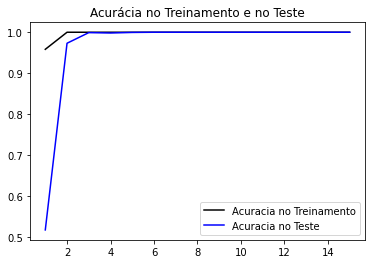

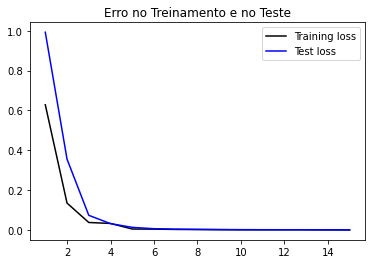

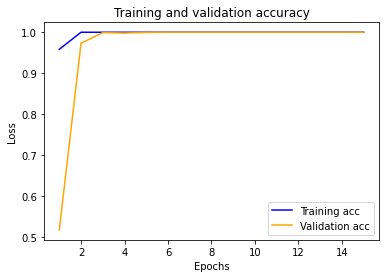

In [16]:
'''
Plotando as Curvas de Validação e de Erro - Aprendizado do Modelo
'''
history = abreDataFramecsv(path_model, nome_History)
#history = history.to_dict()
acc = history.loc[3,'Values']
val_acc = history.loc[1,'Values']
loss = history.loc[2,'Values']
val_loss = history.loc[0,'Values']

from ast import literal_eval

acc = literal_eval(acc)
val_acc = literal_eval(val_acc)
loss = literal_eval(loss)
val_loss = literal_eval(val_loss)


epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,'k', label='Acuracia no Treinamento')
plt.plot(epochs, val_acc, 'b', label='Acuracia no Teste')
plt.title('Acurácia no Treinamento e no Teste')
plt.legend()
plt.figure()
plt.plot(epochs, loss,'k', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Erro no Treinamento e no Teste')
plt.legend()
plt.show()
 
plt.figure()
acc_values = acc
val_acc_values = val_acc
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc_values, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
'''
# =============================================================================
# COMPUTANDO ESTATISTICAS
# =============================================================================
'''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import validation_curve

def computaStats_Classification(modelo,nome,X_a,y_a):
    print("Estatisticas do Modelo - "+nome)
    #predição
    y_pred = modelo.predict([X_a])
    y_true = y_a
    #Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    #Convert validation observations to one hot vectors
    Y_true = np.argmax(y_a,axis = 1) 
    #MEAN SQUARE ERROR
    
    print("Erro medio quadratico: ", mean_squared_error(Y_true, Y_pred_classes))
    
    #Acurácia
    print("Acuracia: ", accuracy_score(Y_true, Y_pred_classes))
    
    #Precisão
    print("Precisao: ", precision_score(Y_true, Y_pred_classes,average=None))
    
    #Recall
    print("Recall: ", recall_score(Y_true, Y_pred_classes,average=None))
    
    #F1 - Score
    print("F1 -Score: ", f1_score(Y_true, Y_pred_classes,average=None))
    

computaStats_Classification(model,'ConvNet_Noise_Class - Treino',X_train,y_train)
# print("--------**********-------------***********---------------**************")
computaStats_Classification(model,'ConvNet_Noise_Class - Testes',X_test,y_test)

Estatisticas do Modelo - ConvNet_Noise_Class - Treino
Erro medio quadratico:  0.0
Acuracia:  1.0
Precisao:  [1. 1. 1.]
Recall:  [1. 1. 1.]
F1 -Score:  [1. 1. 1.]
Estatisticas do Modelo - ConvNet_Noise_Class - Testes
Erro medio quadratico:  0.0
Acuracia:  1.0
Precisao:  [1. 1. 1.]
Recall:  [1. 1. 1.]
F1 -Score:  [1. 1. 1.]


In [18]:
a

NameError: ignored